In [15]:
import pandas as pd
import cv2
import numpy as np
import matplotlib.pyplot as plt
import json
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score


read the csv after finding horizontal threshold, vertical thresholds. make it such that it follows the given format

final csv is the csv that has columns Id, Top-Left, Bottom-Right, Top, Left, Bottom, Right, Top_box, Bottom_box, Left_box, Right_box

Id - refers to box ID -> int

Top-Left,Bottom-Right - refers to the xy coordinates of topleft and bottomright coordinate of a bounding box

Top/Left/Bottom/Right - refers to the coordinates of edge centers

Top_box/Bottom_box/Left_box/Right_box - refers to the nearest box from current box such that the words across paragraphs or columns should not get connected -> List:[dist, nearest box ID]


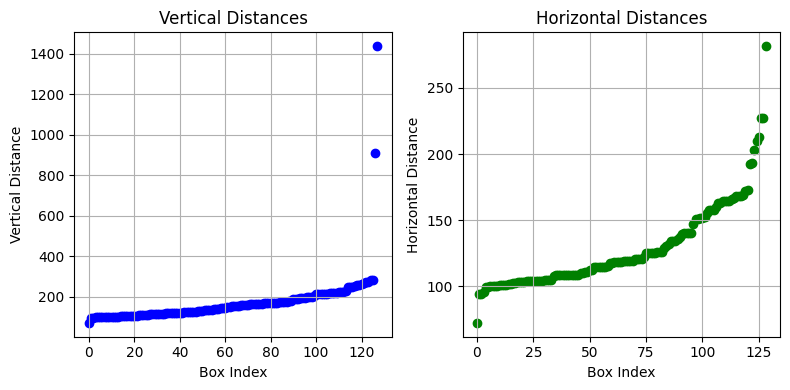

[72.17340230306452, 94.19129471453293, 95.56411460375699, 99.6318222256323, 99.73590125927574, 100.2845950283492, 100.53108971855423, 100.57832768544127, 101.2780825252927, 102.45974819410792, 103.04368005850722, 103.26301370771628, 103.58571330062848, 103.59174677550331, 104.00480758118829, 104.0768946500615, 104.51435308128735, 104.8343932113884, 107.91895106977273, 108.16769388315534, 108.4665847162157, 108.4665847162157, 108.77959367454909, 108.77959367454909, 109.59242674564699, 110.58141796884321, 112.16059914247963, 114.12712210513327, 114.47707194019246, 114.67017920976666, 114.76933388322858, 115.04890264578798, 117.65202930676547, 118.11964273566018, 118.55905701379376, 118.76973520219703, 118.90016820845966, 119.2193356800817, 119.30004191114101, 120.31728886573201, 120.67829133692605, 121.01652779682617, 124.51606322077485, 124.82487732819929, 125.1329293191844, 125.15790027001891, 125.80143083447024, 126.05752655038096, 130.3006139663202, 131.94885372749548, 132.0151506456

In [16]:
df = pd.read_csv('CSV/TLBR_159.csv')
def parse_coordinates(coord_str):
    # Parse the string as a JSON array
    coord_list = json.loads(coord_str)
    # Extract 'x' and 'y' values
    x, y = coord_list
    return int(x), int(y)

# Create the 'euclidean' DataFrame and initialize it with columns
euclidean = pd.DataFrame(columns=['Id', 'Top', 'Bottom', 'Left', 'Right', 'Top_Box', 'Bottom_Box', 'Left_Box', 'Right_Box'])

for index, row in df.iterrows():
    top_left = parse_coordinates(row['Top-Left'])
    bottom_right = parse_coordinates(row['Bottom-Right'])
    box_id = row['Id']
    # Calculate edge centers
    top_center = (top_left[0] + (bottom_right[0] - top_left[0]) / 2, top_left[1])
    bottom_center = (top_left[0] + (bottom_right[0] - top_left[0]) / 2, bottom_right[1])
    left_center = (top_left[0], top_left[1] + (bottom_right[1] - top_left[1]) / 2)
    right_center = (bottom_right[0], top_left[1] + (bottom_right[1] - top_left[1]) / 2)

    # Initialize neighbor values to -1 and 0
    top_box = (-1, 0)
    bottom_box = (-1, 0)
    left_box = (-1, 0)
    right_box = (-1, 0)

    # Add the row to the 'euclidean' DataFrame
    euclidean.loc[index] = [box_id, top_center, bottom_center, left_center, right_center, top_box, bottom_box, left_box, right_box]

def euclidean_distance(point1, point2):
    return np.sqrt((point1[0] - point2[0]) ** 2 + (point1[1] - point2[1]) ** 2)
vertical_distances = []
horizontal_distances = []
def find_nearest_box(row, direction):
    min_distance = float('inf')
    nearest_box = [-1, 0]

    for index, other_row in euclidean.iterrows():
        if row['Id'] != other_row['Id']:
            distance = float('inf')
            calc = euclidean_distance([(row['Top'][0]+row['Bottom'][0])/2, (row['Top'][1]+row['Bottom'][1])/2  ],[ (other_row['Top'][0]+other_row['Bottom'][0])/2, (other_row['Top'][1]+other_row['Bottom'][1])/2 ])
            if(direction == 'Top'):
                if(row['Top'] < other_row['Bottom']):
                    # distance = euclidean_distance((row['Top']+row['Bottom'])/2, (other_row['Top']+other_row['Bottom'])/2)
                    distance = calc
            if(direction == 'Bottom'):
                if(row['Bottom'] > other_row['Top']):
                    # distance = euclidean_distance((row['Top']+row['Bottom'])/2, (other_row['Top']+other_row['Bottom'])/2)
                    distance = calc
            if(direction == 'Left'):
                if(row['Left'] < other_row['Right']):
                    # distance = euclidean_distance((row['Top']+row['Bottom'])/2, (other_row['Top']+other_row['Bottom'])/2)
                    distance = calc
            if(direction == 'Right'):
                if(row['Right'] > other_row['Left']):
                    # distance = euclidean_distance((row['Top']+row['Bottom'])/2, (other_row['Top']+other_row['Bottom'])/2)
                    distance = calc
            if distance < min_distance:
                min_distance = distance
                nearest_box = [min_distance, other_row['Id']+1]

    return nearest_box

# Iterate through the 'euclidean' DataFrame to find the nearest boxes in each direction

for index, row in euclidean.iterrows():
    euclidean.at[index, 'Top_Box'] = find_nearest_box(row, 'Top')
    euclidean.at[index, 'Bottom_Box'] = find_nearest_box(row, 'Bottom')
    euclidean.at[index, 'Left_Box'] = find_nearest_box(row, 'Left')
    euclidean.at[index, 'Right_Box'] = find_nearest_box(row, 'Right')
    if(euclidean.at[index, 'Top_Box'][0] != -1):
        vertical_distances.append(euclidean.at[index, 'Top_Box'][0])
    if(euclidean.at[index, 'Left_Box'][0] != -1):
        horizontal_distances.append(euclidean.at[index, 'Left_Box'][0])
    if(euclidean.at[index, 'Top_Box'][0] > 100):
        euclidean.at[index, 'Top_Box'][1] = 0
    if(euclidean.at[index, 'Bottom_Box'][0] > 100):
        euclidean.at[index, 'Bottom_Box'][1] = 0
    if(euclidean.at[index, 'Left_Box'][0] > 100):
        euclidean.at[index, 'Left_Box'][1] = 0
    if(euclidean.at[index, 'Right_Box'][0] > 100):
        euclidean.at[index, 'Right_Box'][1] = 0
vertical_distances.sort()
horizontal_distances.sort()
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.scatter(range(len(vertical_distances)), vertical_distances, marker='o', color='blue')
plt.xlabel('Box Index')
plt.ylabel('Vertical Distance')
plt.title('Vertical Distances')
plt.grid()

# Create a scatter plot for horizontal distances
plt.subplot(1, 2, 2)
plt.scatter(range(len(horizontal_distances)), horizontal_distances, marker='o', color='green')
plt.xlabel('Box Index')
plt.ylabel('Horizontal Distance')
plt.title('Horizontal Distances')
plt.grid()

# Adjust layout and display the plots
plt.tight_layout()
plt.show()

print(vertical_distances)
print(horizontal_distances)
# In this example, I've used sample lists for vertical and horizontal distances. You should replace these lists with your actual data. The code creates two subplots: one for vertical distances and one for horizontal distances, and it displays them side by side.
print(euclidean)

In [17]:
img = cv2.imread('images/159.jpg')

Given below are two functions to visualize the document image and the connections established.

visualize_bboxes() can be used to visualize a document image with the bounding boxes around words. Bounding box information is given in the CSVs provided

make_connections() can be used to verify and visualize the connections established between words such that it satisfies the given criteria of grouping words in a logical paragraph. This function has to be used after getting the final csv in the specified format

In [18]:
def visualize_bboxes(img):
  img_2 = img.copy()
  for index, rows in df.iterrows():
    top_left = (int(rows['Top-Left'].split(',')[0][1:]),int(rows['Top-Left'].split(',')[1][:-1]))
    bottom_right = (int(rows['Bottom-Right'].split(',')[0][1:]),int(rows['Bottom-Right'].split(',')[1][:-1]))
    print(top_left)
    cv2.rectangle(img_2, top_left, bottom_right, (255, 0, 0), 2)

  plt.imshow(img_2)

In [19]:
def make_connections(image):
#   print(image)
  image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#   print(image_rgb)

  image_with_boxes = image_rgb.copy()

  for index, row in euclidean.iterrows():
      left = int(row['Left'][0])
      right = int(row['Right'][0])
      top = int(row['Top'][1])
      bottom = int(row['Bottom'][1])
      box_id = int(row['Id'])

      width = right - left
      height = bottom - top

      top_left = (left, top)
      bottom_right = (right, bottom)

      cv2.rectangle(image_with_boxes, top_left, bottom_right, (255, 0, 0), 2)

      label_position = (left, top - 10)
      cv2.putText(image_with_boxes, str(box_id), label_position, cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1)

      top_adjacent_id = int(row['Top_Box'][1])
      bottom_adjacent_id = int(row['Bottom_Box'][1])
      left_adjacent_id = int(row['Left_Box'][1])
      right_adjacent_id = int(row['Right_Box'][1])
      
      print(bottom_adjacent_id)
      
      if top_adjacent_id != 0:
          top_adjacent_row = euclidean[euclidean['Id'] == top_adjacent_id-1].iloc[0]
          top_adjacent_center = int(top_adjacent_row['Bottom'][0]) , int(top_adjacent_row['Bottom'][1])
          cv2.line(image_with_boxes, (int(left) + width // 2, int(top)), top_adjacent_center, (0, 255, 0), 2)

      if bottom_adjacent_id != 0:
          bottom_adjacent_row = euclidean[euclidean['Id'] == bottom_adjacent_id-1].iloc[0]
          bottom_adjacent_center = int(bottom_adjacent_row['Top'][0]) , int(bottom_adjacent_row['Top'][1])
          cv2.line(image_with_boxes, (int(left) + width // 2, int(bottom)), (int(bottom_adjacent_center[0]), int(bottom_adjacent_center[1])), (0, 255, 0), 2)

      if left_adjacent_id != 0:
          left_adjacent_row = euclidean[euclidean['Id'] == left_adjacent_id-1].iloc[0]
          left_adjacent_center = int(left_adjacent_row['Right'][0]) , int(left_adjacent_row['Right'][1])
          cv2.line(image_with_boxes, (int(left), int(top) + height // 2), (int(left_adjacent_center[0]), int(left_adjacent_center[1])), (0, 255, 0), 2)

      if right_adjacent_id != 0:
          right_adjacent_row = euclidean[euclidean['Id'] == right_adjacent_id-1].iloc[0]
          right_adjacent_center = int(right_adjacent_row['Left'][0]) , int(right_adjacent_row['Left'][1])
          cv2.line(image_with_boxes, (int(right), int(top) + height // 2), (int(right_adjacent_center[0]), int(right_adjacent_center[1])), (0, 255, 0), 2)

  return image_with_boxes

0
0
2
0
0
0
0
0
0
0
6
0
0
0
0
0
0
0
0
0
0
0
0
30
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
49
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
88
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


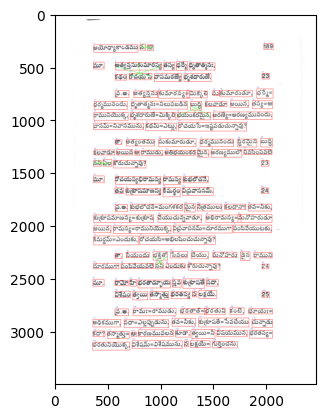

In [20]:
# visualize_bboxes(img)
plt.imshow(make_connections(img))

In [21]:
# import cv2
# import numpy as np

# # Load image, grayscale, Gaussian blur, Otsu's threshold
# image = cv2.imread('images/159.jpg')
# gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
# blur = cv2.GaussianBlur(gray, (7,7), 0)
# thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

# # Create rectangular structuring element and dilate
# kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5,5))
# dilate = cv2.dilate(thresh, kernel, iterations=10)

# # Find contours and draw rectangle
# cnts = cv2.findContours(dilate, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
# cnts = cnts[0] if len(cnts) == 2 else cnts[1]
# for c in cnts:
#     x,y,w,h = cv2.boundingRect(c)
#     cv2.rectangle(image, (x, y), (x + w, y + h), (36,255,12), 2)
# print(len(cnts))
# # cv2.imshow('thresh', thresh)
# # cv2.imshow('dilate', dilate)
# cv2.imshow('image', image)
# cv2.waitKey()